In [1]:
import pandas as pd
import os

# Specify the folder containing the CSV files
folder_path = r'D:\federated learning\data\cicid'  # Replace with the path to your dataset

# List of files to load (update these based on your files)
files = [
    r'D:\federated learning\data\cicid\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Friday-WorkingHours-Morning.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Monday-WorkingHours.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Tuesday-WorkingHours.pcap_ISCX.csv',
    r'D:\federated learning\data\cicid\Wednesday-WorkingHours.pcap_ISCX.csv'
]

df_list = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, low_memory=False)  # Read each file
    df_list.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(df_list, axis=0, ignore_index=True)

# Display the first few rows
print(combined_df.head())
output_file = r"D:\federated learning\data\cicid\CICIDS_combined_dataset.csv"
combined_df.to_csv(output_file, index=False)

print(f"Combined dataset saved to {output_file}")


    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
# Step 2: Check for any missing values
df = df.dropna()  # Drop rows with missing values

# Step 3: Encode the 'Label' column (normal vs attack)
df[' Label'] = df[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)

# Step 4: Select relevant features (drop 'Label' as it's the target)
X = df.drop(' Label', axis=1).values
y = df[' Label'].values

# Step 5: Replace inf and handle large values
X = np.where(np.isinf(X), np.nan, X)  # Replace inf with NaN
X = np.nan_to_num(X, nan=np.nanmean(X))  # Replace NaNs with column mean

# Step 6: Standardize the numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader for IID setup (optional)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 8: Simulating Non-IID Data Split for Clients
def split_noniid_data(X, y, num_clients):
    """
    Split data in a non-IID fashion among clients.
    Each client gets data with biased label distributions.
    """
    non_iid_data = []
    unique_labels = np.unique(y)
    
    # Split data by labels
    label_indices = {label: np.where(y == label)[0] for label in unique_labels}
    
    for client_id in range(num_clients):
        client_data_indices = []
        for label in unique_labels:
            # Each client gets a portion of data for each label (biased distribution)
            num_samples = int(len(label_indices[label]) / num_clients)
            selected_indices = np.random.choice(label_indices[label], num_samples, replace=False)
            client_data_indices.extend(selected_indices)
            
            # Remove selected indices to avoid overlap between clients
            label_indices[label] = np.setdiff1d(label_indices[label], selected_indices)
        
        # Add the client's data to the list
        client_data_X = X[client_data_indices]
        client_data_y = y[client_data_indices]
        non_iid_data.append((client_data_X, client_data_y))
    
    return non_iid_data

num_clients = 5
client_data_splits = split_noniid_data(X_train, y_train, num_clients)

# Example of how to convert each client's data to PyTorch tensors
client_datasets = []
for client_data_X, client_data_y in client_data_splits:
    client_X_tensor = torch.tensor(client_data_X, dtype=torch.float32)
    client_y_tensor = torch.tensor(client_data_y, dtype=torch.long)
    client_datasets.append(TensorDataset(client_X_tensor, client_y_tensor))

# Print client data sizes for verification
for i, dataset in enumerate(client_datasets):
    print(f"Client {i+1} data size: {len(dataset)} samples")


C:\Users\Dell\AppData\Local\Temp\ipykernel_17848\1255895172.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Label'] = df[' Label'].apply(lambda x: 1 if x != 'BENIGN' else 0)


Client 1 data size: 110671 samples
Client 2 data size: 88536 samples
Client 3 data size: 70829 samples
Client 4 data size: 56664 samples
Client 5 data size: 45330 samples


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch.utils.data import DataLoader
import torch.nn.functional as F
from opacus import PrivacyEngine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def adversarial_attack(model, data, target, epsilon=0.1):
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.sign()
    return perturbed_data.detach()

In [3]:
class Client:
    def __init__(self, client_id, model, dataset, lr=0.001, mu=0.1, epsilon=0.2, delta=1e-5):
        self.client_id = client_id
        self.model = copy.deepcopy(model)
        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.mu = mu
        self.epsilon = epsilon
        self.delta = delta
        self.privacy_engine = PrivacyEngine()
        self.model, self.optimizer, self.dataloader = self.privacy_engine.make_private(
            module=self.model,
            optimizer=self.optimizer,
            data_loader=self.dataloader,
            noise_multiplier=0.3,
            max_grad_norm=1.5
        )
        self.grad_tracker = [torch.zeros_like(param) for param in self.model.parameters()]

    def train_local(self, global_model, epochs=1, adv_training=True, fkd=True):
        self.model.train()
        global_params = list(global_model.parameters())

        for epoch in range(epochs):
            for data, target in self.dataloader:
                data, target = data.to(torch.float32), target.to(torch.long)
                if adv_training:
                    data = adversarial_attack(self.model, data, target)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)

                # FedDyn regularization
                fed_dyn_reg = 0.0
                for param, g_param, z in zip(self.model.parameters(), global_params, self.grad_tracker):
                    fed_dyn_reg += torch.sum(param * (self.mu * (param - g_param.detach()) - z))
                loss += fed_dyn_reg

                if fkd:
                    with torch.no_grad():
                        global_output = global_model(data)
                    distill_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(output, dim=1), F.softmax(global_output, dim=1)
                    )
                    loss += 0.4 * distill_loss

                loss.backward()
                self.optimizer.step()

        # Update the client’s historical gradient (FedDyn)
        with torch.no_grad():
            for i, (param, g_param) in enumerate(zip(self.model.parameters(), global_params)):
                self.grad_tracker[i] -= self.mu * (param.detach() - g_param.detach())

        return self.model.state_dict()


In [4]:
class Server:
    def __init__(self, model, num_clients, mu=0.1):
        self.global_model = model
        self.num_clients = num_clients
        self.clients = []
        self.mu = mu
        self.h_dict = {}  # Drift term for FedDyn

    def register_client(self, client):
        self.clients.append(client)
        self.h_dict[client.client_id] = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def aggregate_weights_feddyn(self, client_updates):
        new_global_weights = copy.deepcopy(self.global_model.state_dict())

        for key in new_global_weights.keys():
            avg_update = torch.stack([update[0][key] - (1 / self.mu) * update[1][key] for update in client_updates])
            new_global_weights[key] = avg_update.mean(dim=0)

        return new_global_weights

    def federated_training(self, rounds=10, epochs=1, adv_training=True, fkd=True):
        for r in range(rounds):
            # Adaptive client selection based on drift norm (FedDyn)
            drift_norms = {client.client_id: torch.norm(torch.cat([v.view(-1) for v in self.h_dict[client.client_id].values()]))
                           for client in self.clients}
            sorted_clients = sorted(self.clients, key=lambda x: drift_norms[x.client_id], reverse=True)
            selected_clients = sorted_clients[:max(1, len(self.clients) // 2)]

            print(f"Round {r+1} | Selected Clients: {[c.client_id for c in selected_clients]}")

            client_updates = []
            for client in selected_clients:
                state_dict, h_new = client.train_local(self.global_model, self.h_dict[client.client_id], epochs, adv_training, fkd)
                client_updates.append((state_dict, self.h_dict[client.client_id]))
                self.h_dict[client.client_id] = h_new

            # FedDyn Aggregation
            new_weights = self.aggregate_weights_feddyn(client_updates)
            self.global_model.load_state_dict(new_weights)

    def evaluate_model(self, test_loader):
        self.global_model.eval()
        y_true, y_pred = [], []
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.float32), target.to(torch.long)
                output = self.global_model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                predictions = torch.argmax(output, dim=1)
                y_true.extend(target.numpy())
                y_pred.extend(predictions.numpy())

        # Evaluation Metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        return accuracy, precision, recall, f1


In [16]:
input_size = X_train.shape[1]
server_model = MLP(input_size)
server = Server(server_model, num_clients)

In [17]:
for i in range(num_clients):
    client = Client(i, server_model, client_datasets[i])
    server.register_client(client)

C:\Users\Dell\anaconda3\Lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [37]:
server.federated_training(rounds=35, epochs=5, adv_training=True, dynamic_fed=True)

C:\Users\Dell\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Round 1 completed.
Round 2 completed.
Round 3 completed.
Round 4 completed.
Round 5 completed.
Round 6 completed.
Round 7 completed.
Round 8 completed.
Round 9 completed.
Round 10 completed.
Round 11 completed.
Round 12 completed.
Round 13 completed.
Round 14 completed.
Round 15 completed.
Round 16 completed.
Round 17 completed.
Round 18 completed.
Round 19 completed.
Round 20 completed.
Round 21 completed.
Round 22 completed.
Round 23 completed.
Round 24 completed.
Round 25 completed.
Round 26 completed.
Round 27 completed.
Round 28 completed.
Round 29 completed.
Round 30 completed.
Round 31 completed.
Round 32 completed.
Round 33 completed.
Round 34 completed.
Round 35 completed.


Evaluation Metrics
Accuracy=0.9147
Recall=0.8894
Precision=0.9000
Estimated Confusion Matrix:
 [[451  49]
 [ 55 445]]


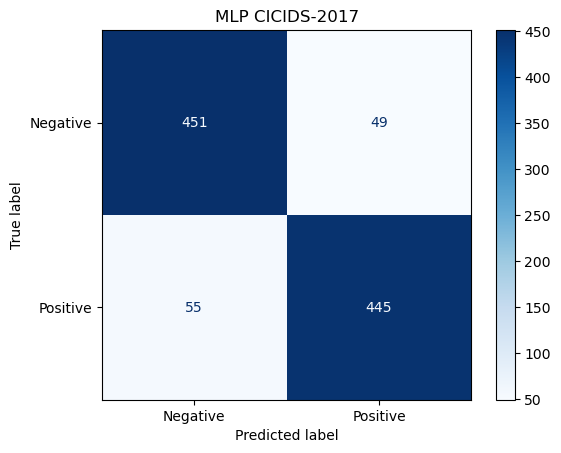

In [5]:
server.evaluate_model(DataLoader(test_dataset, batch_size=32, shuffle=False))